# Análise Generalizada de SAM (Spectral Angle Mapper)

Este notebook permite configurar parâmetros operacionais (RPM, Diâmetro de Falha) e realizar automaticamente:
1.  **Busca de Sinais Reais**: Seleção robusta de múltiplos sinais de referência no dataset.
2.  **Geração de Sinais Sintéticos**: Criação de sinais via métodos FFT e Impulso para as condições especificadas.
3.  **Comparação Quantitativa**: Cálculo da métrica SAM par-a-par e estatística (Média/Desvio).

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.spatial.distance import cosine
import random

# Adicionar src ao path para importar módulos do projeto
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

import importlib
importlib.reload(bu)
importlib.reload(gsd)
importlib.reload(gid)
importlib.reload(ssd)
print('Modules reloaded.')

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

## 1. Configuração de Parâmetros
Defina aqui as condições operacionais para a análise.

In [2]:
# --- Parâmetros de Entrada ---
TARGET_RPM = 1750          # Rotação do eixo (Ex: 1730, 1750, 1772, 1797)
TARGET_DIAMETER_MM = 0.5   # Diâmetro da falha alvo em mm (aprox 0.021")
NUM_SAMPLES = 20            # Número de amostras reais para usar na média do SAM

# --- Constantes do Sistema ---
FS = 12000                 # Frequência de Amostragem (Hz)
N_POINTS = 4096            # Tamanho do segmento

In [9]:
# --- Configuração de Sweep de Parâmetros ---

# RPMs disponíveis no dataset CWRU
RPMS = [1730, 1750, 1772, 1797]

# Diâmetros de falha em mm (aproximadamente 0.007", 0.014", 0.021", 0.028")
DIAMETERS_MM = [0.1778, 0.3556, 0.5334, 0.7112]

# Labels convenientes para visualização
CWru_DIA_MAP = {
    0.1778: '0.007"',
    0.3556: '0.014"',
    0.5334: '0.021"',
    0.7112: '0.028"'
}

# Grade de K por tipo de falha (valores expandidos com foco em menores amplitudes)
K_GRID = {
    'OR': [0.01, 0.02, 0.05, 0.1],   # Outer race (Pista Externa)
    'IR': [0.01, 0.05, 0.5, 0.8, 1.0],      # Inner race (Pista Interna)
    'B':  [0.005, 0.01, 0.02, 0.03, 0.05, 0.08]       # Ball (Esfera)
}


## 2. Funções Auxiliares
Funções para cálculo do SAM, espectro e filtragem de dados.

In [4]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from general_sam_analysis_utils import (
    calcular_sam_graus,
    get_mag_spectrum,
    get_real_signals_metadata_batch,
    get_normal_signal,
    pad_or_trim,
    apply_antialiasing_filter,
    apply_hanning_window,
    limit_spectrum_frequency,
    apply_lowpass_filter  # <--- NOVA FUNÇÃO
)

# Obs.: a geração do sinal por impulso agora vem de `generate_impulse_data.py` (importado como `gid`).

## 4. Visualização Agregada dos Resultados

A partir de `results_df`, podemos criar visualizações agregadas para entender o efeito de RPM, diâmetro, K e tipo de falha sobre o SAM médio.


In [18]:
# 3. Execução da Análise em Sweep (RPM × Diâmetro × K) + Baseline (Normal vs Real)

results = []

falhas = [
    ('Pista Externa', 'OR', 'outer'),
    ('Pista Interna', 'IR', 'inner'),
    ('Esfera',       'B',  'ball')
]

if 'FREQ_MAX_VALUES' not in locals():
    FREQ_MAX_VALUES = [1200]

print("Iniciando sweep de parâmetros e cálculo de baseline (Normal vs Real)...\n")

# --- Calcular Frequências Naturais do Rolamento (Uma vez) ---
nat_freqs_df = bu.get_bearing_natural_frequencies()

for freq_max in FREQ_MAX_VALUES:
    UPPER_FREQ_LIMIT = freq_max
    print(f"\n--- Iniciando análise para Limite Superior de Frequência: {UPPER_FREQ_LIMIT} Hz ---")

    for rpm in RPMS:
        # 1. Obter Ruído de fundo (Normal) para este RPM
        sinal_normal = get_normal_signal(ssd.dicionario_teste, rpm, N_POINTS)
        
        # --- PREPARAÇÃO DO ESPECTRO NORMAL (BASELINE) ---
        sig_nat_filt = apply_antialiasing_filter(sinal_normal, FS)
        sig_nat_filt = apply_lowpass_filter(sig_nat_filt, FS, cutoff_freq=1200)
        sig_nat_win = apply_hanning_window(sig_nat_filt)
        spec_nat_full = get_mag_spectrum(sig_nat_win)

        # Calcular frequências características para Limite Inferior
        t_inner = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'inner')
        t_outer = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'outer')
        t_ball  = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'ball')
        
        bpfi = t_inner['frequencies']['defect_freq_hz']
        bpfo = t_outer['frequencies']['defect_freq_hz']
        bsf  = t_ball['frequencies']['defect_freq_hz'] 
        
        # Limite Inferior: 0.9 * min(todas as freq falha)
        min_char_freq = min(bpfi, bpfo, bsf)
        LOWER_FREQ_LIMIT = 0.9 * min_char_freq

        # Pre-calcular eixo de frequências
        freq_axis = fftfreq(N_POINTS, 1/FS)[:N_POINTS//2]
        
        # Limitar espectro do Normal
        _, spec_nat_lim = limit_spectrum_frequency(freq_axis, spec_nat_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

        for diam_mm in DIAMETERS_MM:
            for nome, type_code, gen_type in falhas:
                # Grade de K dependente do tipo de falha
                for k_val in K_GRID[type_code]:
                    # 1. Obter Sinais Reais de Referência
                    refs = get_real_signals_metadata_batch(ssd.dicionario_teste, rpm, type_code, diam_mm, NUM_SAMPLES)
                    num_refs = len(refs)

                    # 2. Calcular Frequência de Falha (para Impulso)
                    tandon_coeffs = bu.calculate_tandon_coefficients(diam_mm, rpm, gen_type)
                    char_freq = tandon_coeffs['frequencies']['defect_freq_hz']

                    # --- Geração Sintética (Tandon e Impulso) ---
                    # (Mesmo processo de antes...)
                    try:
                        sig_fft_pure, sig_fft_final = gsd.gerar_sinal_tandon_completo(
                            fs=FS, n_points=N_POINTS, diametro_mm=diam_mm, rpm=rpm,
                            tipo_falha=nome, k_val=k_val, sinal_normal=sinal_normal,
                        )
                        sig_fft_final = apply_antialiasing_filter(sig_fft_final, FS)
                        sig_fft_final = apply_lowpass_filter(sig_fft_final, FS, cutoff_freq=1200)
                        sig_fft_final_win = apply_hanning_window(sig_fft_final)
                    except Exception as e:
                        sig_fft_final_win = np.zeros(N_POINTS)

                    try:
                        sig_imp_pure = gid.gerar_sinal_impulso_completo(
                            fs=FS, duration_points=N_POINTS, defect_freq_hz=char_freq
                        )
                        sig_imp_final = sinal_normal + (k_val * sig_imp_pure)
                        sig_imp_final = apply_antialiasing_filter(sig_imp_final, FS)
                        sig_imp_final = apply_lowpass_filter(sig_imp_final, FS, cutoff_freq=1200)
                        sig_imp_final_win = apply_hanning_window(sig_imp_final)
                    except Exception as e:
                        sig_imp_final_win = np.zeros(N_POINTS)

                    # 3. Calcular SAM e registrar resultados
                    sam_fft_vals = []
                    sam_imp_vals = []
                    sam_real_vs_normal_vals = [] # Lista para armazenar SAM(Real vs Normal)

                    spec_syn_fft_full = get_mag_spectrum(sig_fft_final_win)
                    spec_syn_imp_full = get_mag_spectrum(sig_imp_final_win)

                    # LIMITAR ESPECTROS SINTÉTICOS
                    _, spec_syn_fft_lim = limit_spectrum_frequency(freq_axis, spec_syn_fft_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)
                    _, spec_syn_imp_lim = limit_spectrum_frequency(freq_axis, spec_syn_imp_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

                    for _, sig_real in refs:
                        # Processar sinal Real
                        sig_real_filt = apply_antialiasing_filter(sig_real, FS)
                        sig_real_filt = apply_lowpass_filter(sig_real_filt, FS, cutoff_freq=1200)
                        sig_real_win = apply_hanning_window(sig_real_filt)
                        spec_real_full = get_mag_spectrum(sig_real_win)
                        _, spec_real_lim = limit_spectrum_frequency(freq_axis, spec_real_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

                        # A) SAM: Real vs Sintético (Validação do Modelo)
                        sam_fft_vals.append(calcular_sam_graus(spec_real_lim, spec_syn_fft_lim))
                        sam_imp_vals.append(calcular_sam_graus(spec_real_lim, spec_syn_imp_lim))
                        
                        # B) SAM: Real vs Normal (Baseline / Severidade da Falha Real)
                        # Cálculo: 1 - Cosseno (Distância de Cosseno)
                        # Quanto maior esse valor, mais diferente a falha real é do normal.
                        sam_real_vs_normal_vals.append(1.0 - calcular_sam_graus(spec_real_lim, spec_nat_lim))

                    # Calcular médias
                    mean_fft = float(np.mean(sam_fft_vals)) if sam_fft_vals else np.nan
                    std_fft = float(np.std(sam_fft_vals)) if sam_fft_vals else np.nan

                    mean_imp = float(np.mean(sam_imp_vals)) if sam_imp_vals else np.nan
                    std_imp = float(np.std(sam_imp_vals)) if sam_imp_vals else np.nan
                    
                    # Média do Baseline para este grupo de sinais reais
                    mean_real_vs_normal = float(np.mean(sam_real_vs_normal_vals)) if sam_real_vs_normal_vals else np.nan

                    dia_label = CWru_DIA_MAP.get(min(CWru_DIA_MAP.keys(), key=lambda k: abs(k - diam_mm)), f"{diam_mm:.4f}m")

                    # Armazenar resultados
                    # Nota: 'sam_real_vs_normal_deg' será igual para as linhas FFT e Impulso do mesmo caso real,
                    # mas repetimos para facilitar plotagem lado a lado se necessário.
                    results.append({
                        'rpm': rpm,
                        'diameter_mm': diam_mm,
                        'diameter_label': dia_label,
                        'fault_name': nome,
                        'fault_code': type_code,
                        'freq_max': freq_max,
                        'method': 'fft',
                        'k': k_val,
                        'num_refs': num_refs,
                        'sam_mean_deg': mean_fft,
                        'sam_std_deg': std_fft,
                        'sam_real_vs_normal_deg': mean_real_vs_normal # <--- COLUNA CORRETA
                    })

                    results.append({
                        'rpm': rpm,
                        'diameter_mm': diam_mm,
                        'diameter_label': dia_label,
                        'fault_name': nome,
                        'fault_code': type_code,
                        'freq_max': freq_max,
                        'method': 'impulse',
                        'k': k_val,
                        'num_refs': num_refs,
                        'sam_mean_deg': mean_imp,
                        'sam_std_deg': std_imp,
                        'sam_real_vs_normal_deg': mean_real_vs_normal # <--- COLUNA CORRETA
                    })

# Consolidar em DataFrame
results_df = pd.DataFrame(results)
print(f"Sweep concluído. Total de linhas em results_df: {len(results_df)}")
display(results_df.head())

Iniciando sweep de parâmetros e cálculo de baseline (Normal vs Real)...


--- Iniciando análise para Limite Superior de Frequência: 1200 Hz ---
Sweep concluído. Total de linhas em results_df: 480


,rpm,diameter_mm,diameter_label,fault_name,fault_code,freq_max,method,k,num_refs,sam_mean_deg,sam_std_deg,sam_real_vs_normal_deg
0,1730,0.1778,"0.007""",Pista Externa,OR,1200,fft,0.01,20,0.466886,0.058774,0.558178
1,1730,0.1778,"0.007""",Pista Externa,OR,1200,impulse,0.01,20,0.441914,0.048389,0.558178
2,1730,0.1778,"0.007""",Pista Externa,OR,1200,fft,0.02,20,0.472200,0.066772,0.556317
3,1730,0.1778,"0.007""",Pista Externa,OR,1200,impulse,0.02,20,0.443828,0.031804,0.556317
4,1730,0.1778,"0.007""",Pista Externa,OR,1200,fft,0.05,20,0.374586,0.123415,0.574430


In [20]:
# --- Nova Seção: Comparação Baseline (Sinal Natural vs Falha Real) ---

print("Iniciando análise de Baseline: Sinal Natural vs Falha Real...\n")

results_baseline = []

if 'FREQ_MAX_VALUES' not in locals():
    FREQ_MAX_VALUES = [1200]

for freq_max in FREQ_MAX_VALUES:
    UPPER_FREQ_LIMIT = freq_max
    
    for rpm in RPMS:
        # 1. Obter Sinal Natural
        sinal_natural = get_normal_signal(ssd.dicionario_teste, rpm, N_POINTS)
        
        # 2. Aplicarfiltros
        sig_nat_filt = apply_antialiasing_filter(sinal_natural, FS)
        sig_nat_filt = apply_lowpass_filter(sig_nat_filt, FS, cutoff_freq=1200)
        sig_nat_win = apply_hanning_window(sig_nat_filt)
        
        # 3. Obter Espectro do Sinal Natural
        spec_nat_full = get_mag_spectrum(sig_nat_win)
        
        # Calcular eixo de frequências
        freq_axis = fftfreq(N_POINTS, 1/FS)[:N_POINTS//2]

        # Calcular limite inferior
        t_inner = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'inner')
        t_outer = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'outer')
        t_ball  = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'ball')
        min_char_freq = min(t_inner['frequencies']['defect_freq_hz'], 
                            t_outer['frequencies']['defect_freq_hz'], 
                            t_ball['frequencies']['defect_freq_hz'])
        LOWER_FREQ_LIMIT = 0.9 * min_char_freq
        
        # Limitar espectro do Natural
        _, spec_nat_lim = limit_spectrum_frequency(freq_axis, spec_nat_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

        for diam_mm in DIAMETERS_MM:
            dia_key = min(CWru_DIA_MAP.keys(), key=lambda k: abs(k - diam_mm))
            dia_label = CWru_DIA_MAP.get(dia_key, f"{diam_mm:.4f}m")
            
            for nome, type_code, gen_type in falhas:
                # 4. Obter Sinais Reais de Referência
                refs = get_real_signals_metadata_batch(ssd.dicionario_teste, rpm, type_code, diam_mm, NUM_SAMPLES)
                
                sam_vals = []
                for _, sig_real in refs:
                    # Filtros no sinal Real
                    sig_real_filt = apply_antialiasing_filter(sig_real, FS)
                    sig_real_filt = apply_lowpass_filter(sig_real_filt, FS, cutoff_freq=1200)
                    sig_real_win = apply_hanning_window(sig_real_filt)
                    spec_real_full = get_mag_spectrum(sig_real_win)
                    
                    # Limitar espectro do Real
                    _, spec_real_lim = limit_spectrum_frequency(freq_axis, spec_real_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)
                    
                    # 5. Calcular SAM: Quão diferente (distante) é a FALHA REAL comparada ao SINAL NATURAL?
                    # Alterado para 1.0 - Cosseno (Distância)
                    # Valor próximo de 0 = Falha parece Normal (Ruim/Indetectável)
                    # Valor próximo de 1 (ou 2) = Falha muito diferente (Bom/Detectável)
                    sam_vals.append(1.0 - calcular_sam_graus(spec_real_lim, spec_nat_lim))
                
                if sam_vals:
                    mean_sam = float(np.mean(sam_vals))
                    std_sam = float(np.std(sam_vals))
                else:
                    mean_sam, std_sam = np.nan, np.nan
                
                results_baseline.append({
                    'rpm': rpm,
                    'diameter_mm': diam_mm,
                    'diameter_label': dia_label,
                    'fault_name': nome,
                    'fault_code': type_code,
                    'freq_max': freq_max,
                    'method': 'natural_baseline',
                    'k': 0.0,
                    'num_refs': len(refs),
                    'sam_mean_deg': mean_sam,
                    'sam_std_deg': std_sam
                })

# Criar DataFrame e exibir
df_baseline = pd.DataFrame(results_baseline)
print(f"Análise de Baseline concluída. Total de linhas: {len(df_baseline)}")
print("Amostra dos resultados (Natural vs Real):")
display(df_baseline.head())

Iniciando análise de Baseline: Sinal Natural vs Falha Real...

Análise de Baseline concluída. Total de linhas: 48
Amostra dos resultados (Natural vs Real):


,rpm,diameter_mm,diameter_label,fault_name,fault_code,freq_max,method,k,num_refs,sam_mean_deg,sam_std_deg
0,1730,0.1778,"0.007""",Pista Externa,OR,1200,natural_baseline,0.0,20,0.549310,0.033940
1,1730,0.1778,"0.007""",Pista Interna,IR,1200,natural_baseline,0.0,20,0.612841,0.119430
2,1730,0.1778,"0.007""",Esfera,B,1200,natural_baseline,0.0,20,0.504100,0.054332
3,1730,0.3556,"0.014""",Pista Externa,OR,1200,natural_baseline,0.0,20,0.555352,0.023439
4,1730,0.3556,"0.014""",Pista Interna,IR,1200,natural_baseline,0.0,20,0.604997,0.066453


# Plots


In [25]:
%run add_tandon_scatter_plot.py
plot_method_comparison(results_df, df_baseline)

Funções carregadas: 'plot_tandon_vs_baseline', 'plot_tandon_facet_grid', 'plot_method_comparison'.
Visualização Final e Detalhamento FFT

--- Tabela Comparativa de Desempenho (LaTeX) ---
\begin{table}
\caption{Comparação de Similaridade SAM (Cosseno)}
\begin{tabular}{llrrr}
\toprule
 & method & Baseline & Tandon & Impulse \\
fault_name & diameter_label &  &  &  \\
\midrule
\multirow[t]{3}{*}{Esfera} & 0.007" & 0.5843 & 0.5012 & 0.4944 \\
 & 0.014" & 0.6549 & 0.4200 & 0.4025 \\
 & 0.021" & 0.6478 & 0.4269 & 0.4006 \\
\cline{1-5}
\multirow[t]{3}{*}{Pista Externa} & 0.007" & 0.6218 & 0.4722 & 0.4485 \\
 & 0.014" & 0.6484 & 0.5063 & 0.4287 \\
 & 0.021" & 0.7154 & 0.3856 & 0.3771 \\
\cline{1-5}
\multirow[t]{3}{*}{Pista Interna} & 0.007" & 0.6178 & 0.4288 & 0.4278 \\
 & 0.014" & 0.6494 & 0.4220 & 0.4208 \\
 & 0.021" & 0.7040 & 0.3855 & 0.3865 \\
\cline{1-5}
\bottomrule
\end{tabular}
\end{table}





method                        Baseline    Tandon   Impulse
fault_name    diameter_label                              
Esfera        0.007"          0.584262  0.501222  0.494434
              0.014"          0.654934  0.420001  0.402523
              0.021"          0.647764  0.426923  0.400608
Pista Externa 0.007"          0.621812  0.472200  0.448545
              0.014"          0.648446  0.506330  0.428737
              0.021"          0.715368  0.385590  0.377098
Pista Interna 0.007"          0.617784  0.428842  0.427758
              0.014"          0.649391  0.422010  0.420835
              0.021"          0.703957  0.385477  0.386461

Funções carregadas: 'plot_tandon_vs_baseline', 'plot_tandon_facet_grid', 'plot_method_comparison'.
Gerando gráficos para os diâmetros: ['0.021"']
--- Processando Diâmetro 0.021" ---


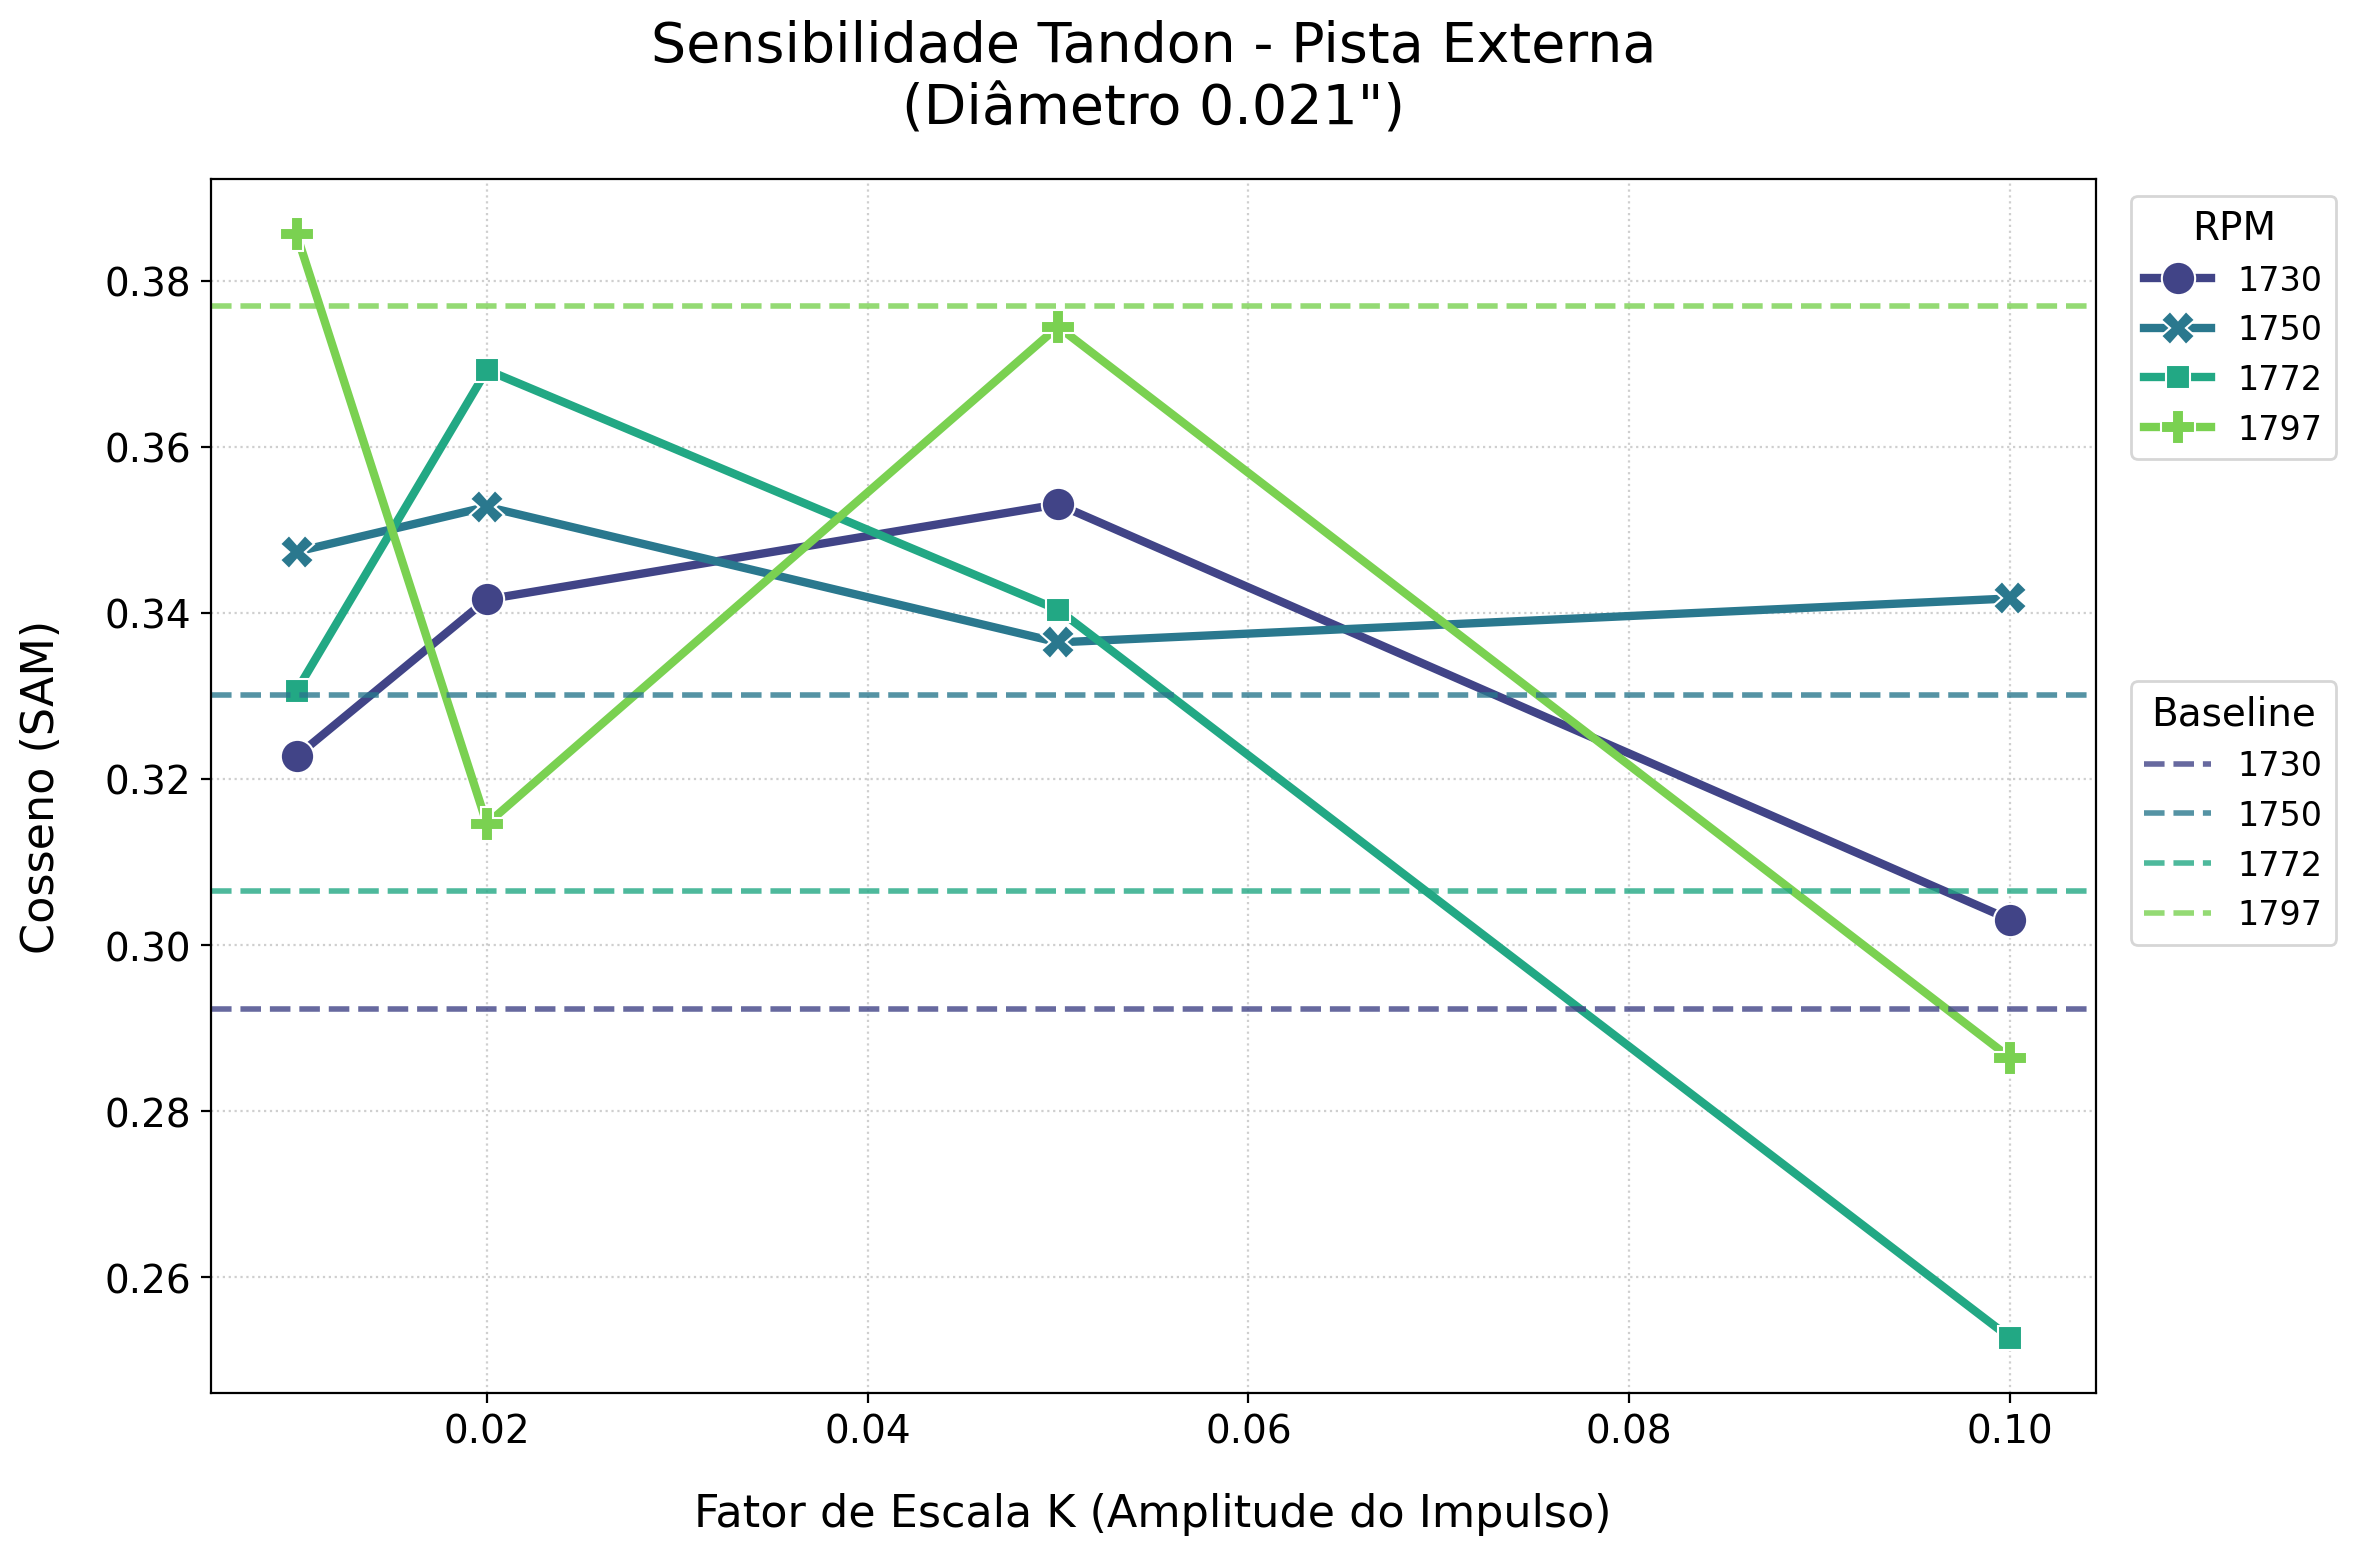

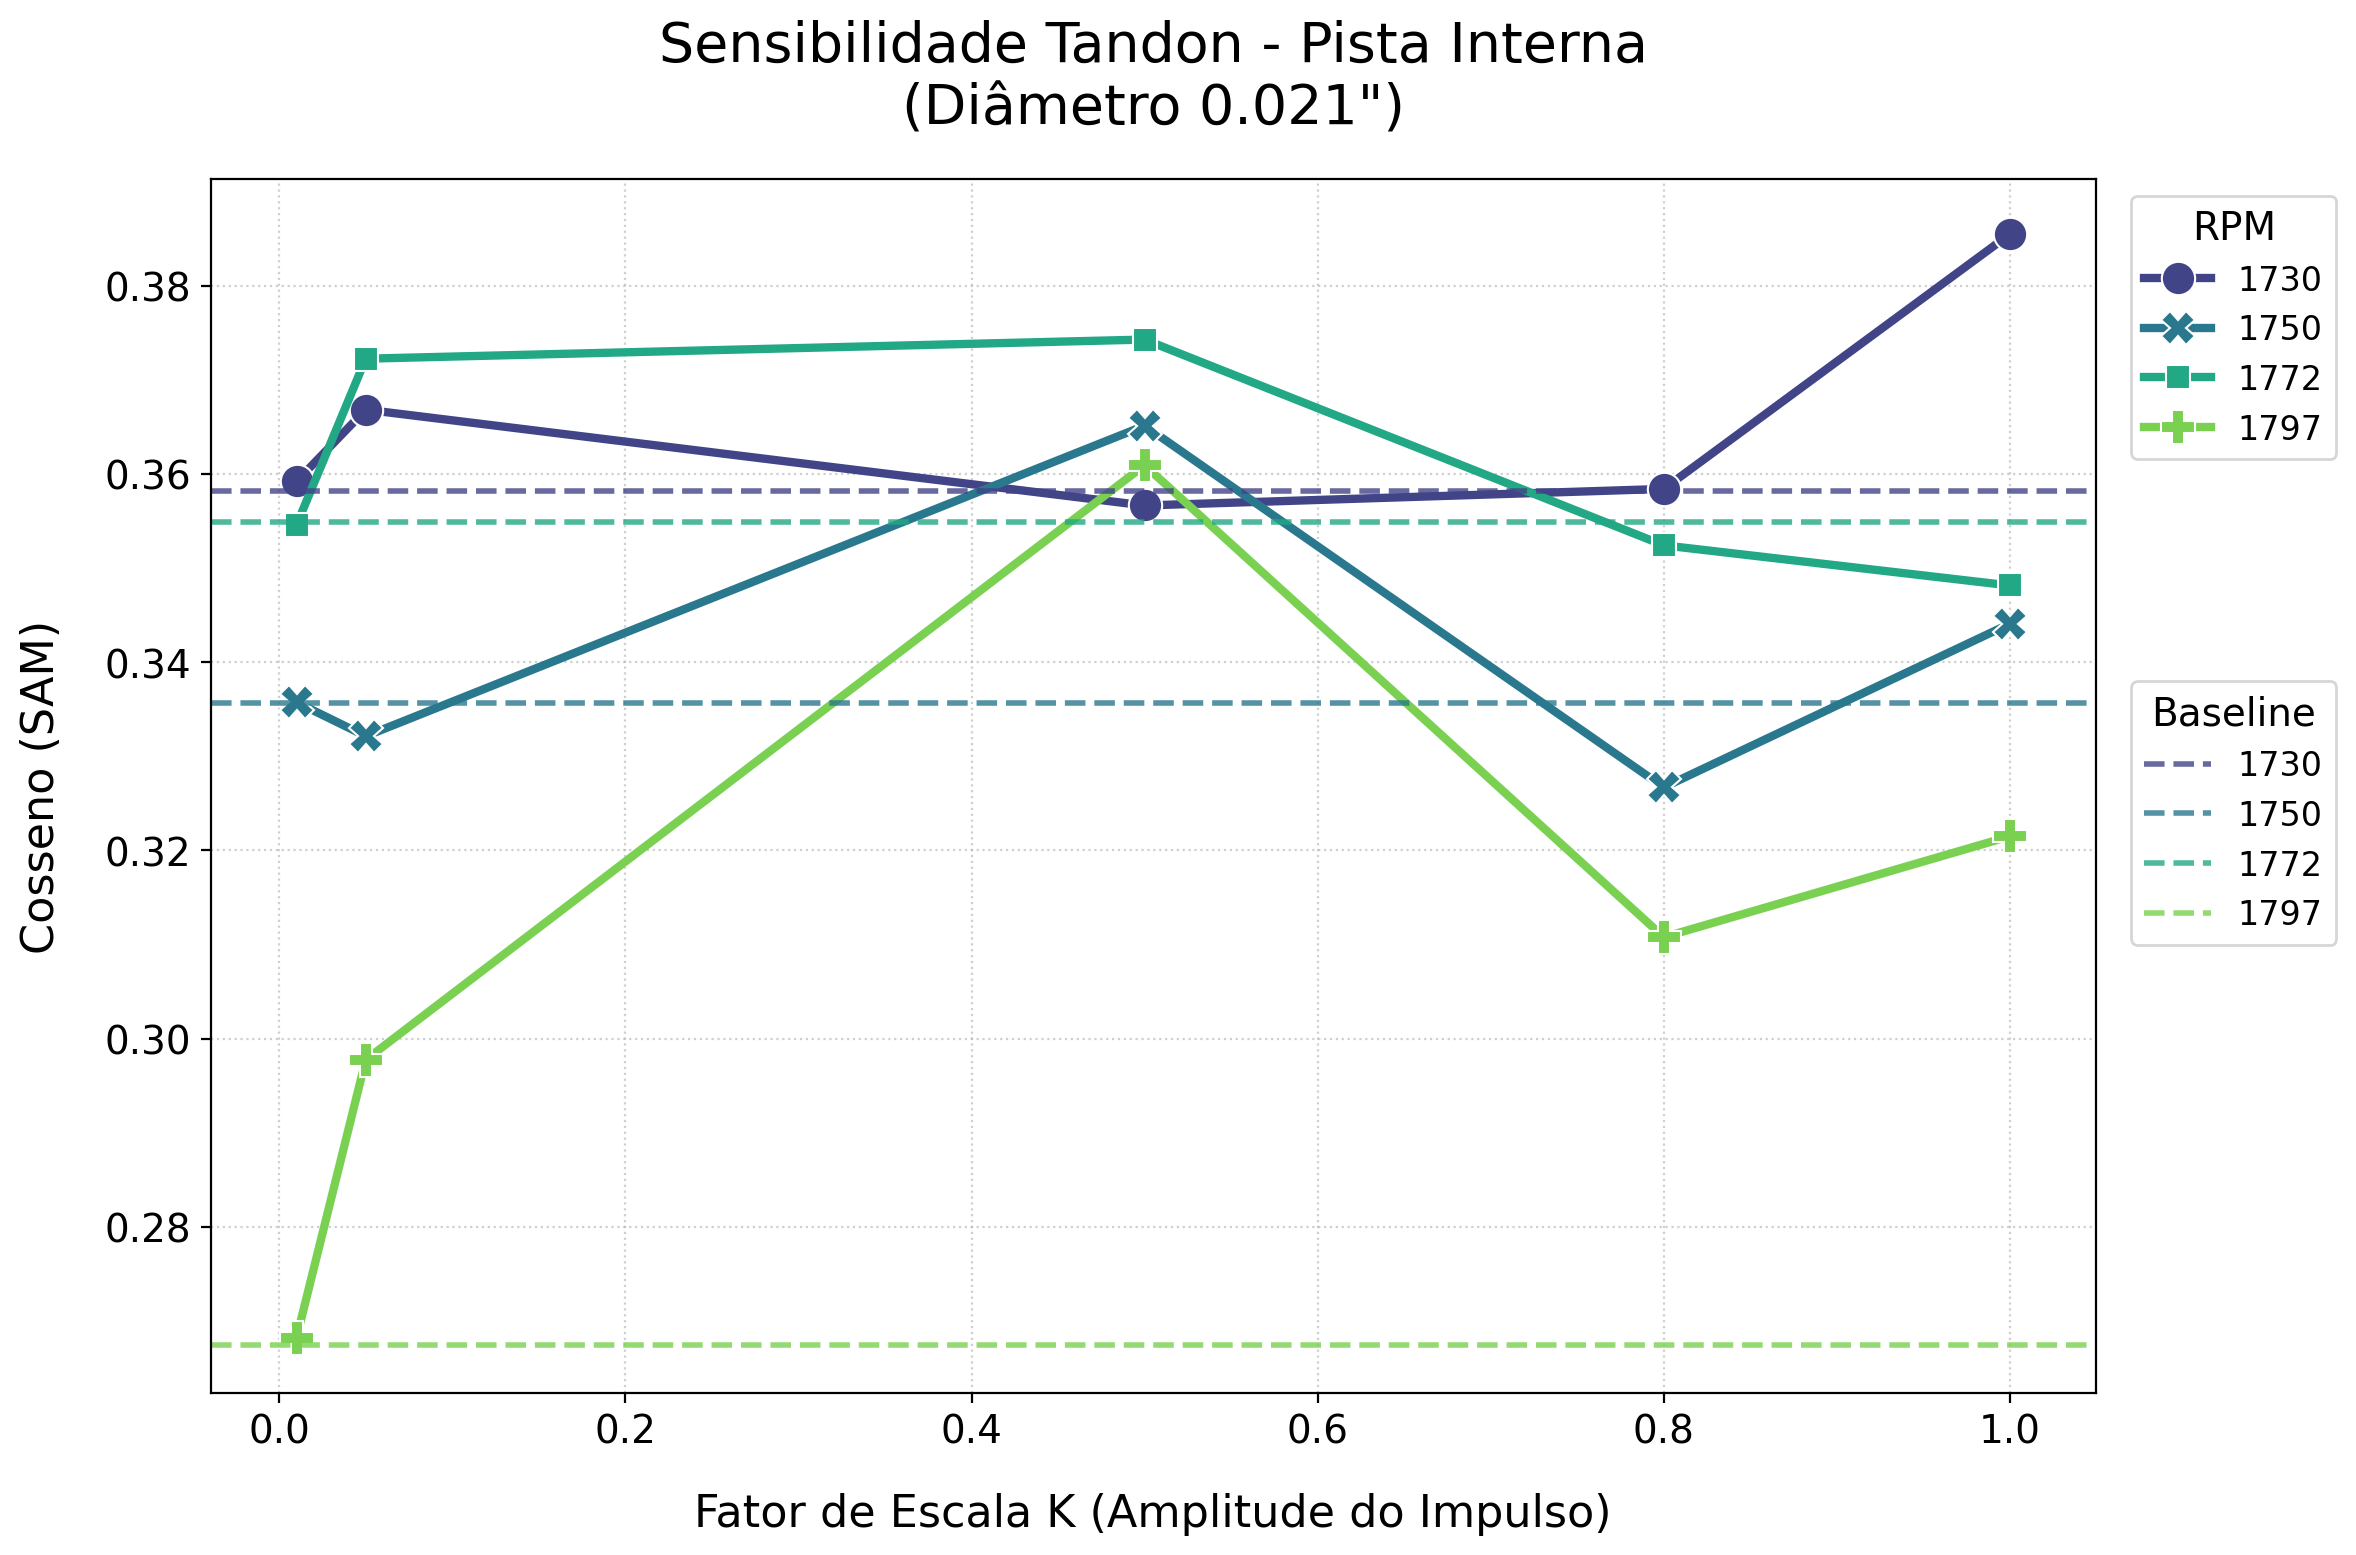

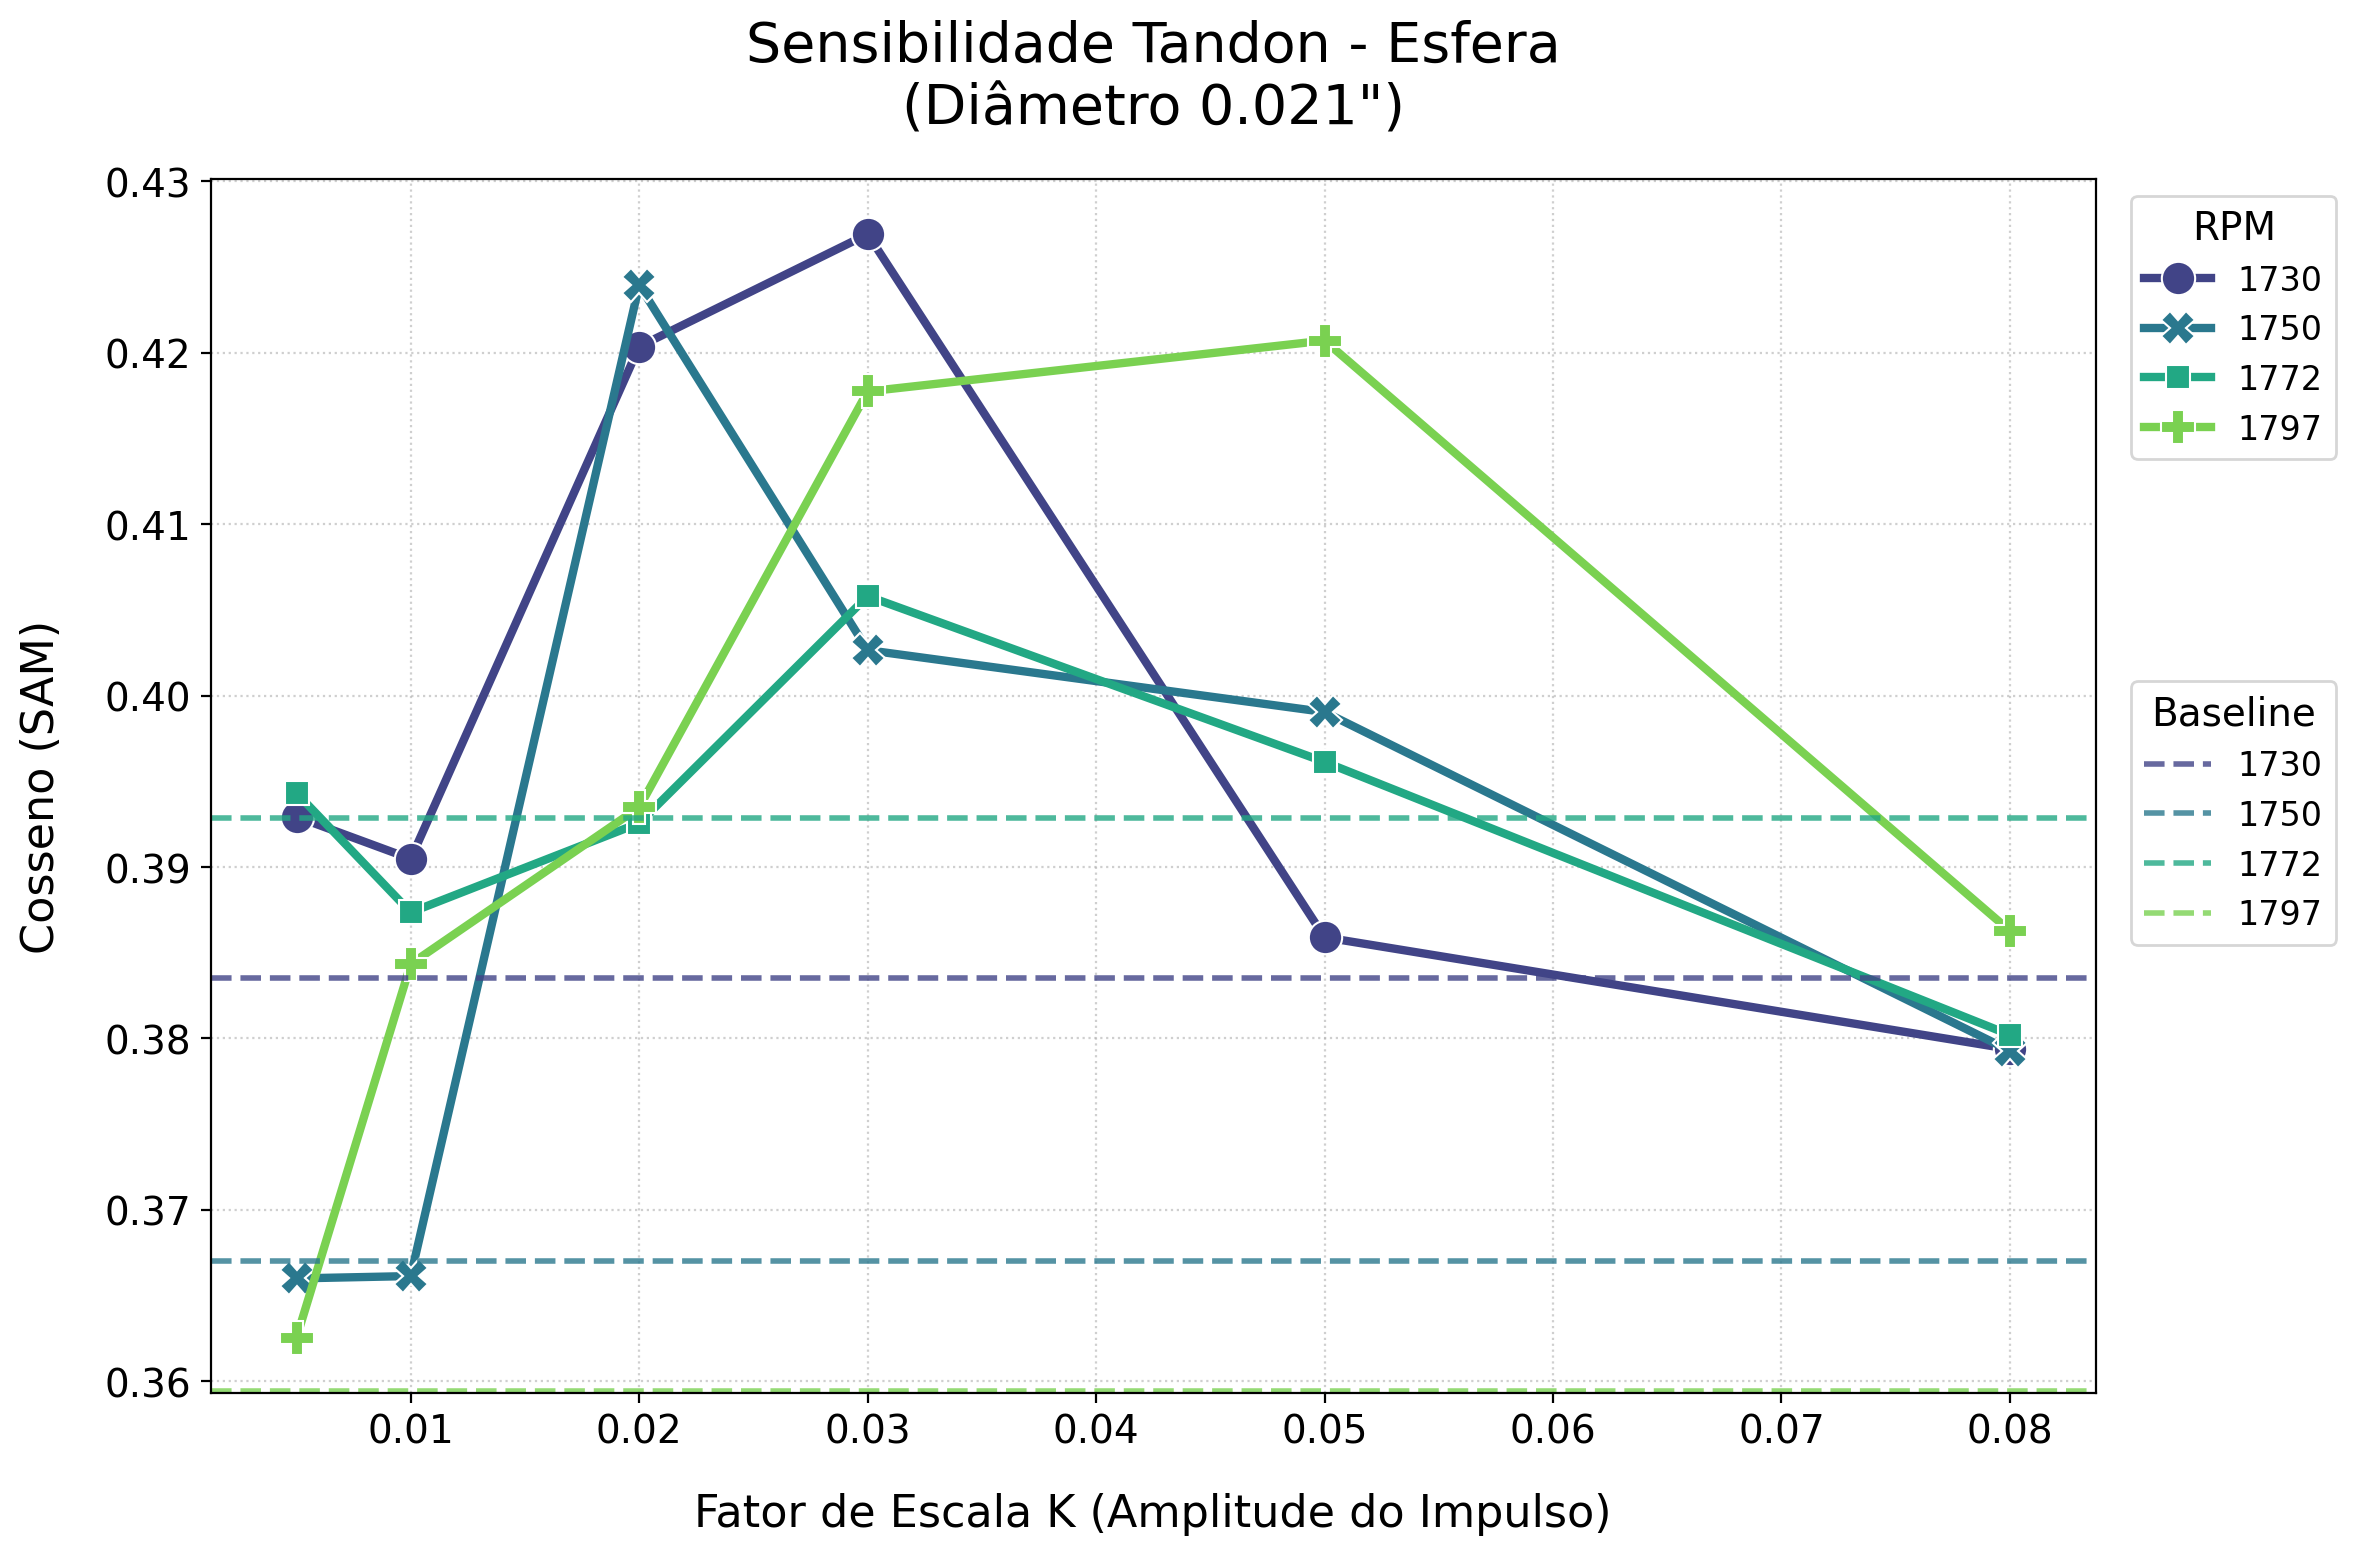

In [22]:
%run add_tandon_scatter_plot.py
plot_tandon_vs_baseline(results_df, target_diameter_label = '0.021"') # Sem argumentos, plota tudo

Funções carregadas: 'plot_tandon_vs_baseline', 'plot_tandon_facet_grid', 'plot_method_comparison'.


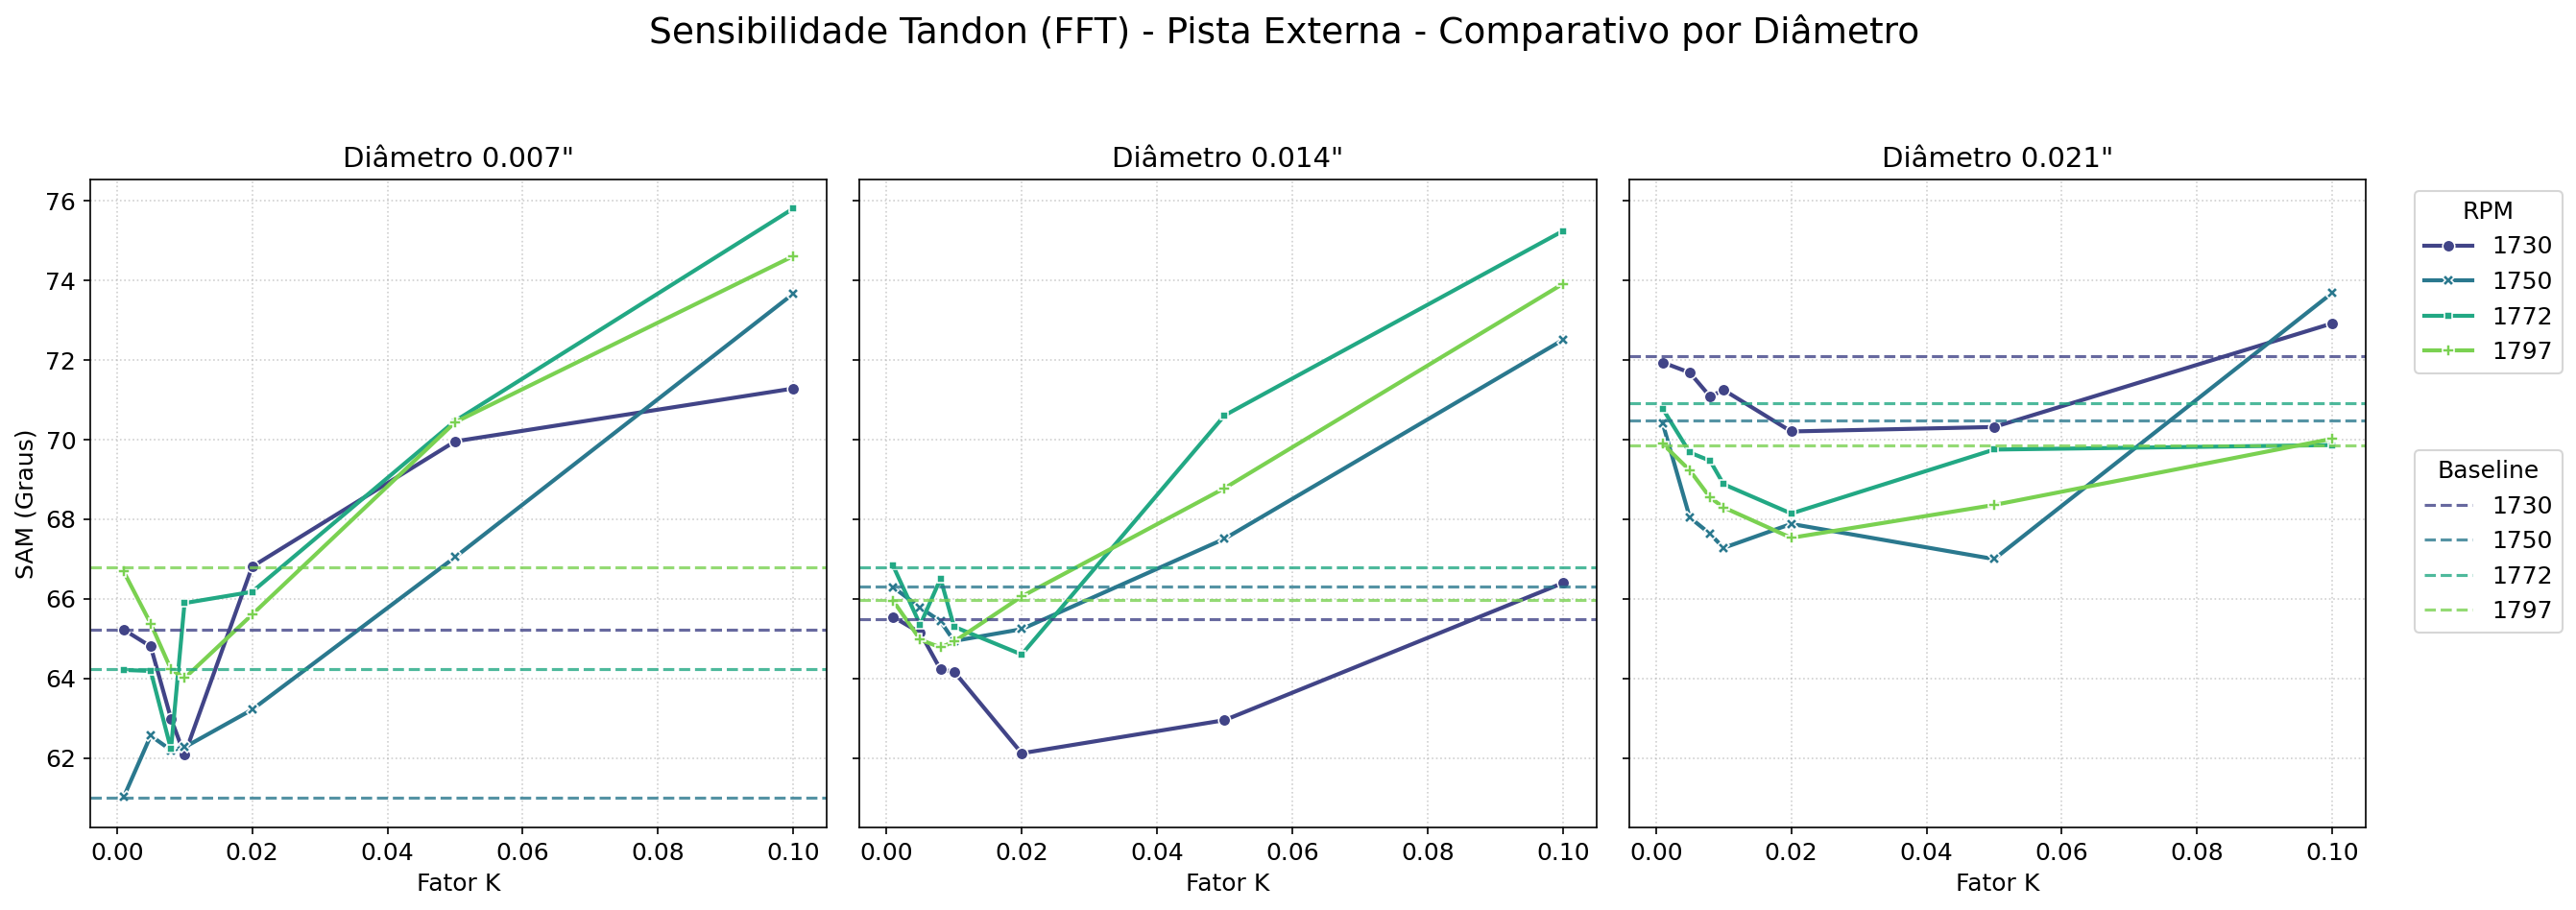

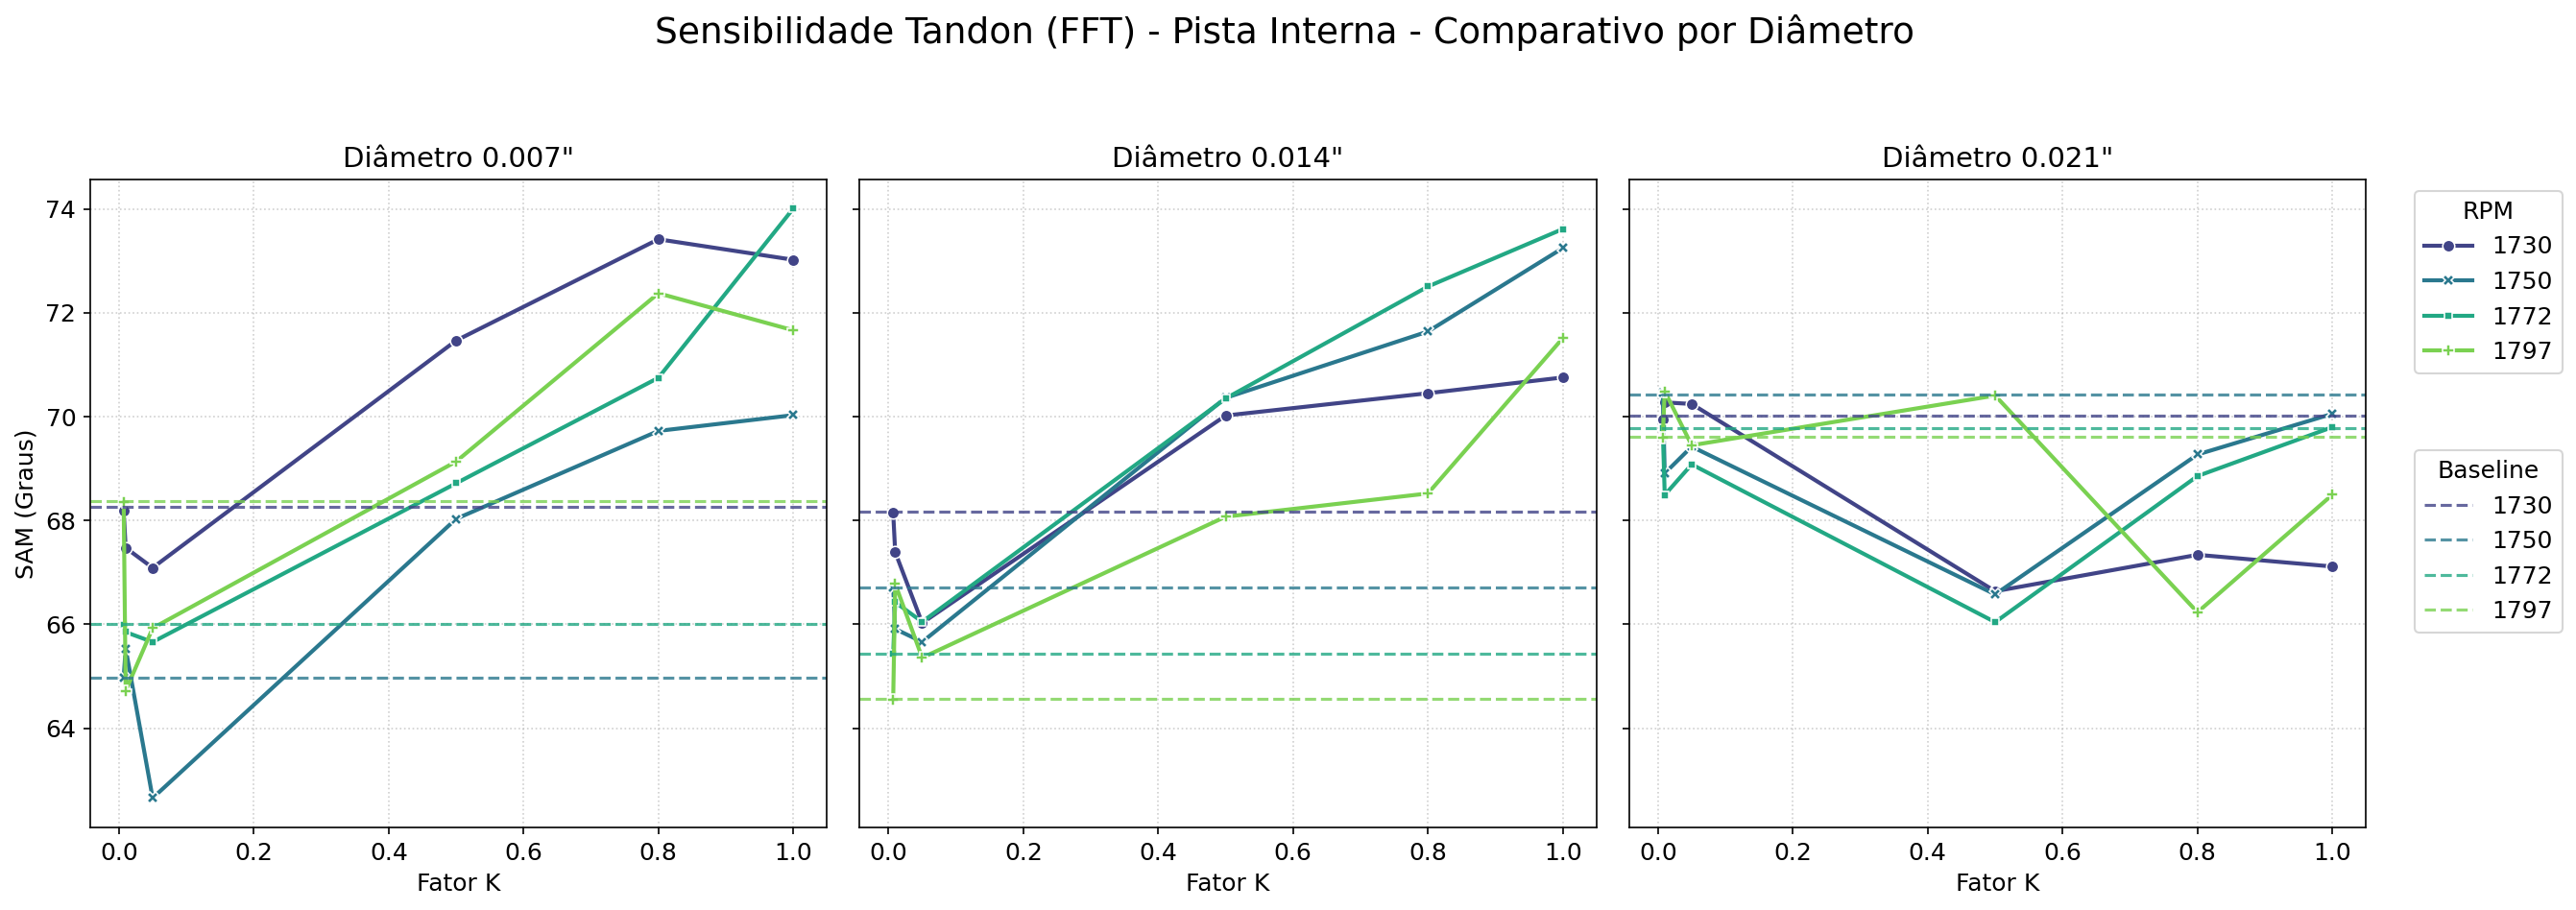

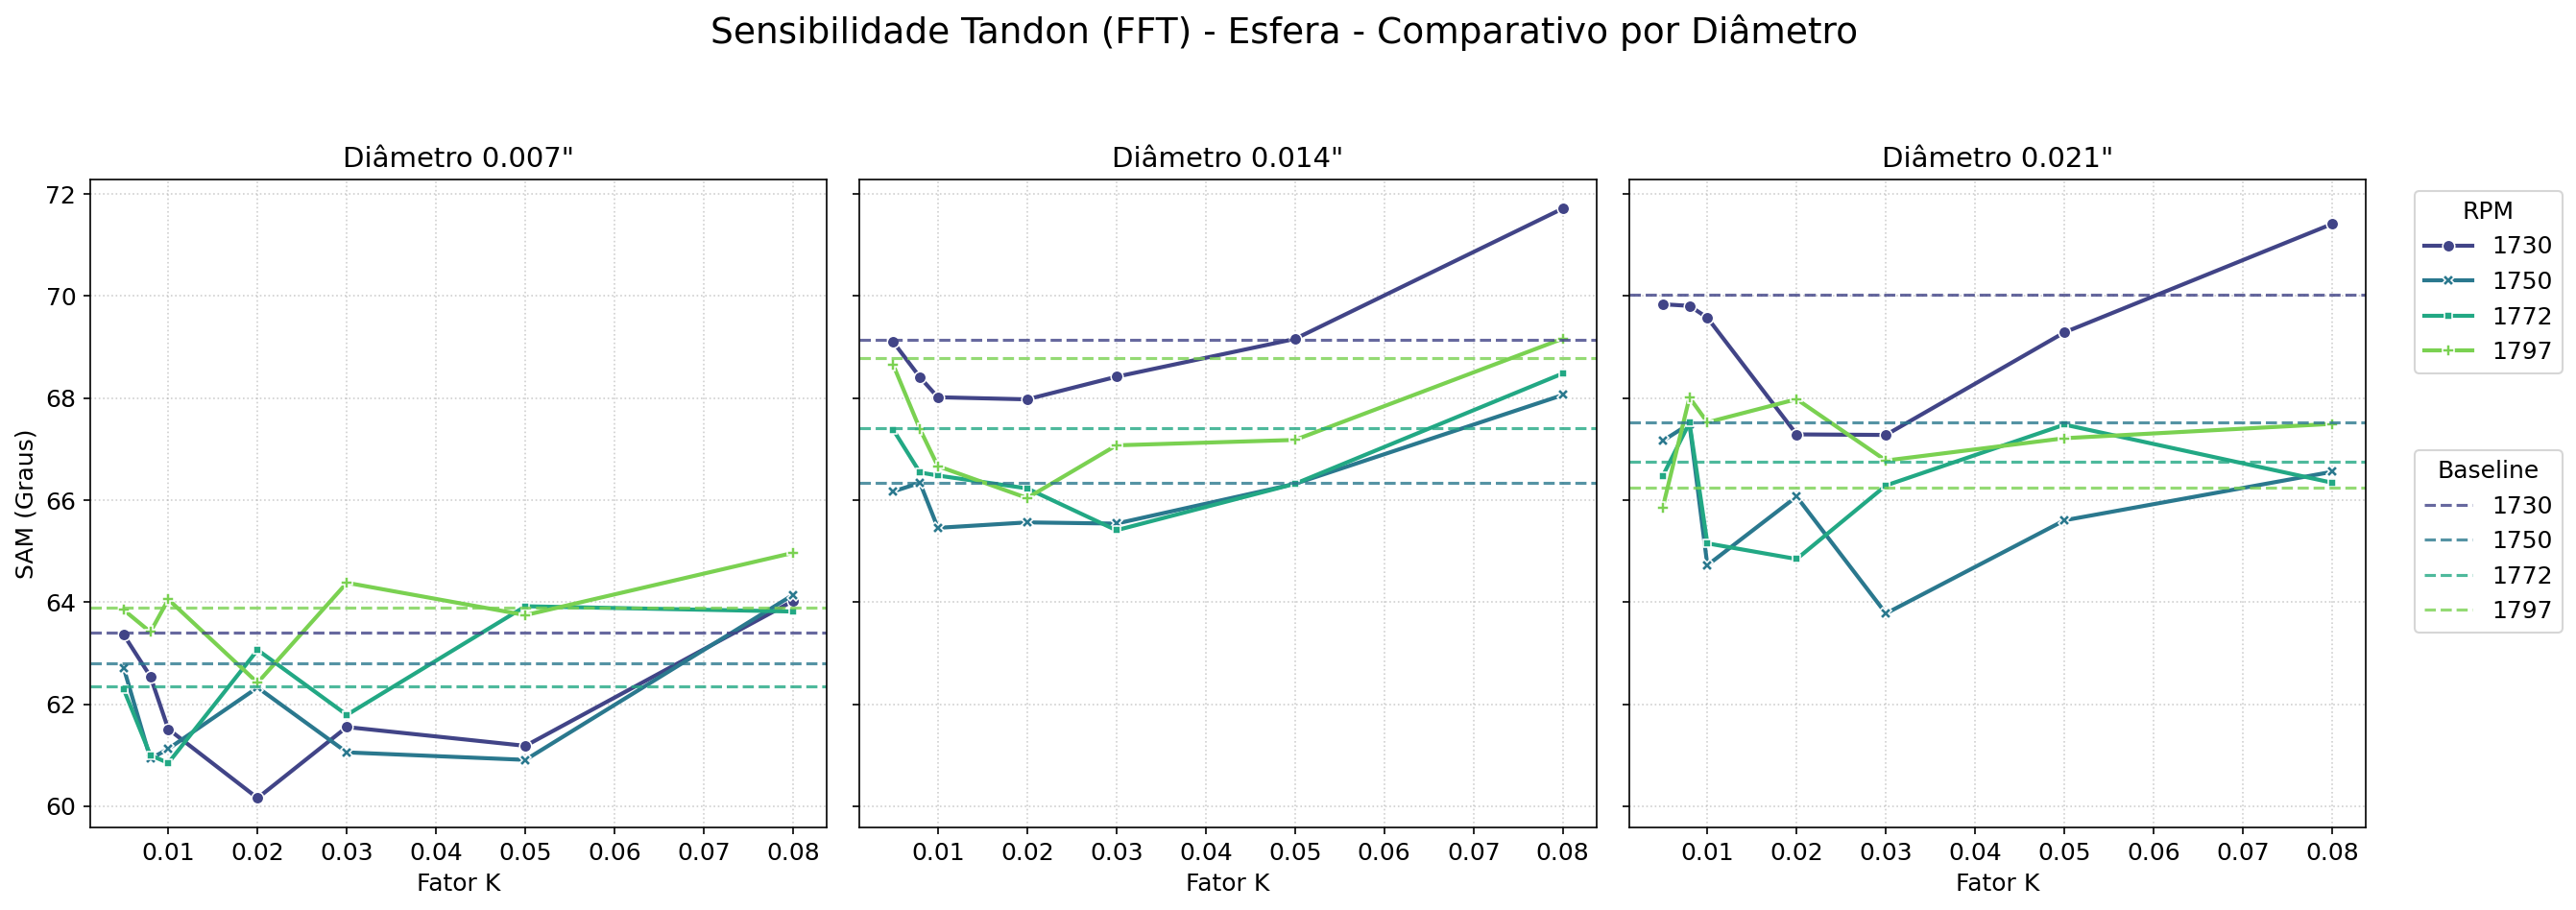

In [13]:
%run add_tandon_scatter_plot.py
plot_tandon_facet_grid(results_df)